# Exploration: simulated cointegrated time series

Cointegrated time series are often visually similar. This notebook explores to what extent changepoint based similarity measures are useful for identifying cointegrated time series in large panels of heterogeneous time series. 

## Setup

In [2]:
source("../scripts/frechet_dist_skeleton.R")
source("../scripts/cointegration_simulations.R")
source("../scripts/eval_cointegration_discrimination.R")
library("not")

## Motivation

Consider the "textbook" example of two cointegrated time series $X_t = (x_{1,t},x_{2,t})$ where $x_{1,t}$ follows a random walk and the cointegrating vector $\boldsymbol{a}^T = (-\gamma,1)$ impliws that $x_{2,t}$ may only wander a fixed distance from $\gamma x_{1,t}$. 

$$x_{1,t} = x_{1,t-1} + u_{1,t}$$
$$x_{2,t} = \gamma x_{1,t} + u_{2,t}$$
$$(u_1,u_2) \sim \mathcal{N}(\boldsymbol{0},\Omega)$$

Simulating the process with $\gamma = 0.7$ and $\Omega = \boldsymbol{I}_2$ the two time series are visually very similar. 

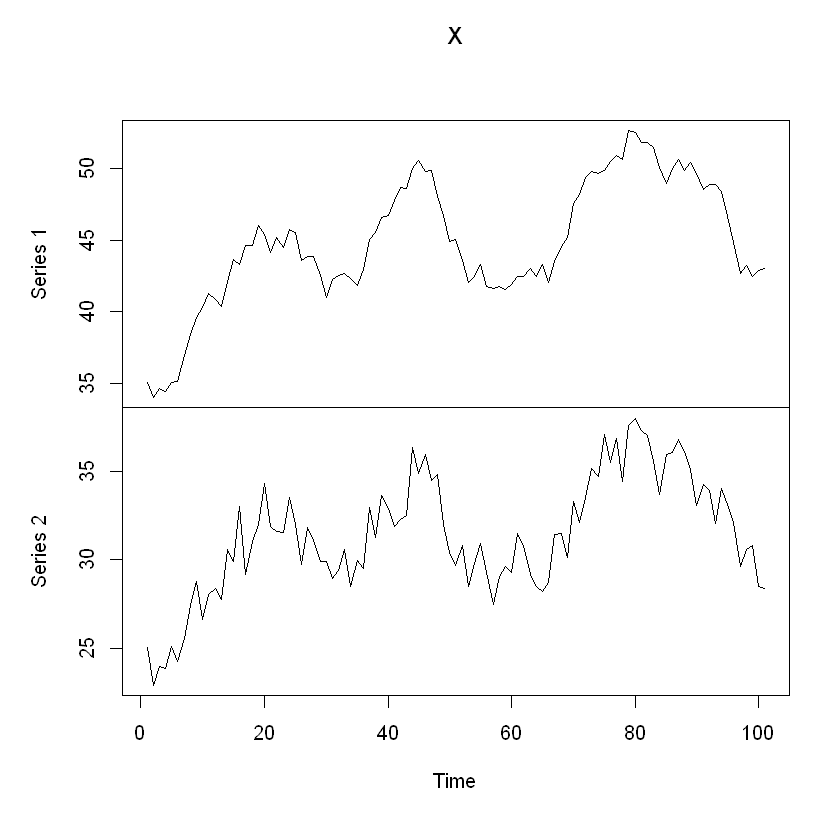

In [21]:
X <- cointegrated.series(100,0.7,diag(2))
plot.ts(X)

Importantly for the proposed method, the changepoints in $x_1$ and $x_2$ identified by the NOT algorithm tend to be very close. 

In [22]:
not.x <- list()
for (i in 1:2) not.x[[i]] <- not(X[,i], contrast = "pcwsLinMean")
cbind(lapply(1:2, function(i) features(not.x[[i]])$cpt))

"19, 35, 45, 53, 65, 78, 94"
"19, 36, 43, 50, 63, 80"


Finally, the piecewise linear approximations from the NOT algorithm are visually similar. In fact, rescaling so that the two time series take values only in $[0,1]$ the changepoint skeletons are almost identical. 

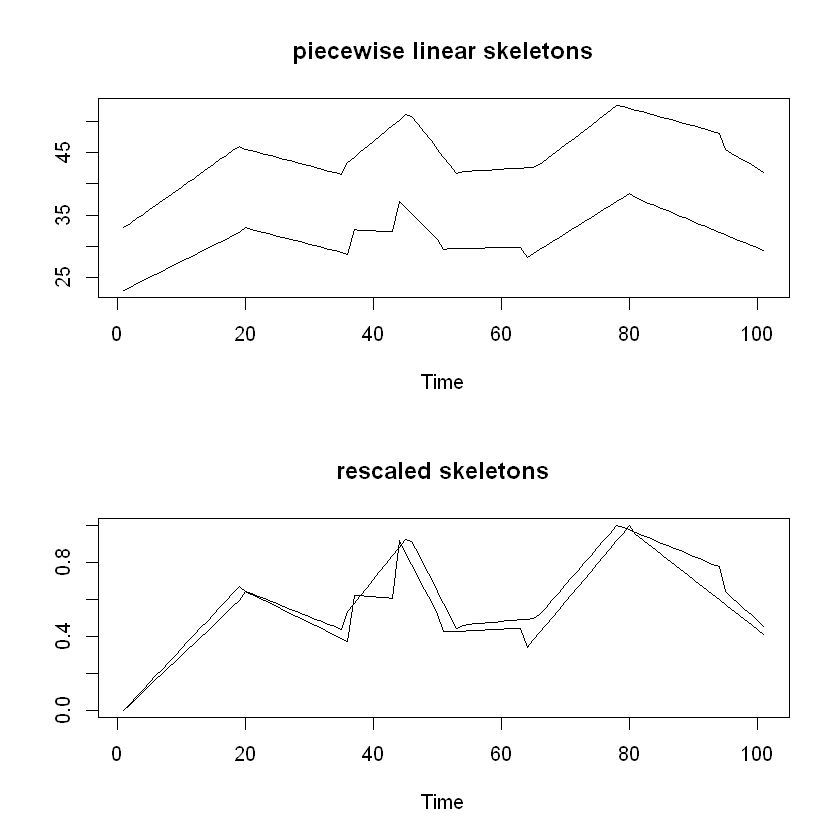

In [36]:
Y <- matrix(unlist(lapply(1:2, function(i) predict(not.x[[i]]))), ncol = 2)

par(mfrow = c(2,1))
ts.plot(Y, main = "piecewise linear skeletons")
ts.plot(apply(Y,2,function(i) (i-min(i))/(max(i)-min(i))), main = "rescaled skeletons")

## Finding cointegrated time series

Here four experiments are run to test to what extent the Frechet distance between changepoint based skeletons can be used to discriminate between co-integrated and non-cointegrated time series. The textbook example from above with various choices for $\gamma$ together with a vector of noise terms $Z_t$ is simulated and distances between all time series are calculated, this is then used to estimate the probability that the distance between the two cointegrated time series will be smallest. Specifically, the simulations estimate the quantity: 

$$\mathbb{P}\left ( d(x_1,x_2) < \underset{j\in \left \{ 1,...,n \right \}}{\inf} d(x_1,z_j) \right )$$

In each simulation $Z_t$ is set to a vector of 50 time series, each time series is simulated up to $T = 100$, and each simulation is repeated for 100 times.

In [4]:
trials <- 100; n <- 50; tt <- 100; C <- diag(2); C.x <- diag(2)
C.X <- diag(50); n.workers <- 8; h <- 5
path.dist <- "../scripts/frechet_dist_skeleton.R"
path.coint <- "../scripts/cointegration_simulations.R"

#### Serially and cross sectionally uncorrelated noise

In the simplest case $Z_t$ is set to be uncorrelated standard Gaussian noise.

In [4]:
g.1.5 <- eval.noise(trials,n,tt,C,1.5,n.workers,path.dist,path.coint)
g.1 <- eval.noise(trials,n,tt,C,1,n.workers,path.dist,path.coint)
g.0.5 <- eval.noise(trials,n,tt,C,0.5,n.workers,path.dist,path.coint)
g.neg.0.5 <- eval.noise(trials,n,tt,C,-0.5,n.workers,path.dist,path.coint)

data.frame(g.1.5,g.1,g.0.5,g.neg.0.5)

g.1.5,g.1,g.0.5,g.neg.0.5
<dbl>,<dbl>,<dbl>,<dbl>
0.99,0.97,0.87,0.23


#### Dependant noise

Here $Z_t$ is set to be cross sectionally uncorrelated dependent noise. With probability $p = 0.5$ each entry in $Z_t$ follows either a stationary AR(1) process or an invertible MA(1) process with parameters draws from a uniform distribution on $(0,1)$.

In [5]:
g.1.5 <- eval.dependant.noise(trials,n,tt,C,1.5,0.5,n.workers,path.dist,path.coint)
g.1 <- eval.dependant.noise(trials,n,tt,C,1,0.5,n.workers,path.dist,path.coint)
g.0.5 <- eval.dependant.noise(trials,n,tt,C,0.5,0.5,n.workers,path.dist,path.coint)
g.neg.0.5 <- eval.dependant.noise(trials,n,tt,C,-0.5,0.5,n.workers,path.dist,path.coint)

data.frame(g.1.5,g.1,g.0.5,g.neg.0.5)

g.1.5,g.1,g.0.5,g.neg.0.5
<dbl>,<dbl>,<dbl>,<dbl>
0.87,0.82,0.74,0


#### Non-stationary noise

Here $Z_t$ is set to be cross sectionally uncorrelated non-stationary noise. Each entry in $Z_t$ is simulated as a random walk, and with probability $p = 0.3$ drift is added where $\delta$ is drawn from a uniform distribution on $(-1,1)$.

In [6]:
g.1.5 <- eval.nonstationary.noise(trials,n,tt,C,1.5,0.3,n.workers,path.dist,path.coint)
g.1 <- eval.nonstationary.noise(trials,n,tt,C,1,0.3,n.workers,path.dist,path.coint)
g.0.5 <- eval.nonstationary.noise(trials,n,tt,C,0.5,0.3,n.workers,path.dist,path.coint)
g.neg.0.5 <- eval.nonstationary.noise(trials,n,tt,C,-0.5,0.3,n.workers,path.dist,path.coint)

data.frame(g.1.5,g.1,g.0.5,g.neg.0.5)

g.1.5,g.1,g.0.5,g.neg.0.5
<dbl>,<dbl>,<dbl>,<dbl>
0.85,0.77,0.57,0


#### cointegrated time series

$Z_t$ is set to be a vector of cointegrated time series with $h = 5$ cointegrating relationships. For the procedure to simulate  such time series see my [stack exchange post](https://quant.stackexchange.com/questions/3930/how-to-simulate-cointegrated-prices/53221#53221).

In [5]:
g.1.5 <- eval.cointegrated.noise(trials,n,h,tt,C.x,C.X,1.5,n.workers,path.dist,path.coint)
g.1 <- eval.cointegrated.noise(trials,n,h,tt,C.x,C.X,1,n.workers,path.dist,path.coint)
g.0.5 <- eval.cointegrated.noise(trials,n,h,tt,C.x,C.X,0.5,n.workers,path.dist,path.coint)
g.neg.0.5 <- eval.cointegrated.noise(trials,n,h,tt,C.x,C.X,-0.5,n.workers,path.dist,path.coint)

data.frame(g.1.5,g.1,g.0.5,g.neg.0.5)

g.1.5,g.1,g.0.5,g.neg.0.5
<int>,<int>,<int>,<int>
80,74,56,0


## Observations

Overall the procedure seems to work well. As $\gamma$ decreases the accuracy of the procedure deteriorates, and the same is true as more dependence is added to the noise vector $Z_t$. Although a properly specified parametric test fort cointegration will tend to out perform the above, the procedure is still worth investigating as it is entirely non parametric. Standard tests for cointegration tend to lose poser become entirely inconsistent when (i) a structural break is present or (ii) the lag structure is mis-specified; however, we would not expect the same to be true for this procedure. 

It is also worth noting that the NOT algorithm is optimize to (i) find changepoints in a parametric model and (ii) find changepoints which optimally describe some scalar valued time series. The skeletons provided by the NOT algorithm with piecewise linear contrast function may therefore not be optimal for comparing time series similarity.

### Negative $\gamma$

The procedure works very poorly when $\gamma$ is negative. To see why consider the original example this time run with $\gamma = -0.7$. 

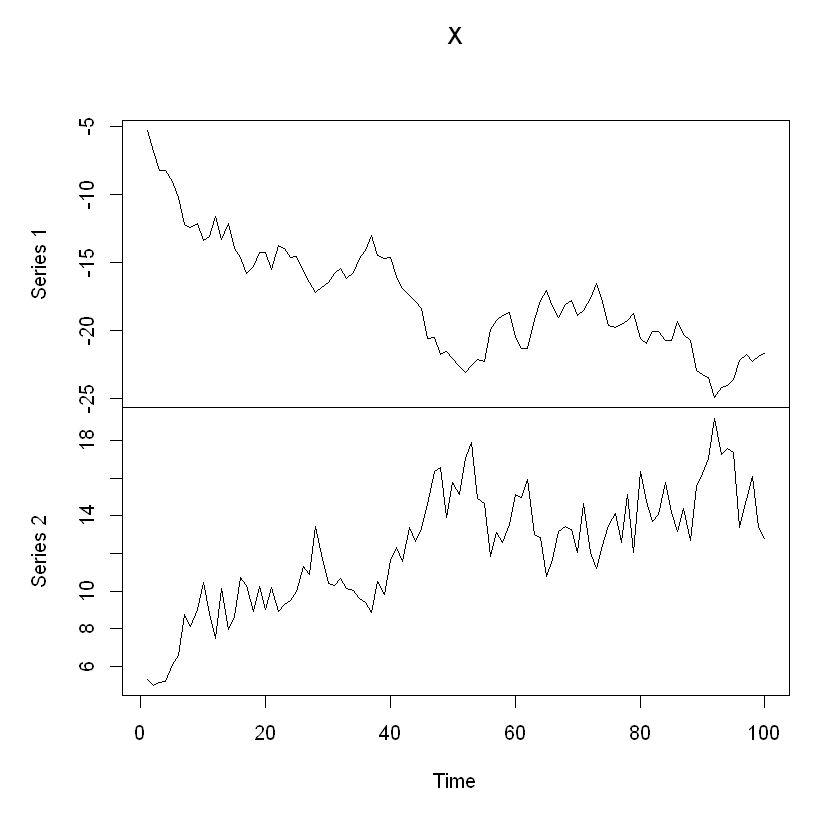

In [6]:
X <- cointegrated.series(100,-0.7,diag(2))
plot.ts(X)

Again, the NOT algorithm identified similarly placed changepoints for the two time series. 

In [7]:
not.x <- list()
for (i in 1:2) not.x[[i]] <- not(X[,i], contrast = "pcwsLinMean")
cbind(lapply(1:2, function(i) features(not.x[[i]])$cpt))

"10, 17, 27, 37, 48, 64, 85, 91"
"10, 27, 37, 53, 62, 92"


However, the two skeletons for the curve time series are always very far from each other. This is because  $x_{2,t}$ may only wander a fixed distance from -$\gamma x_{1,t}$, so the two time series will tend to be close only when $x_{1,t}$ is close to zero. Reflecting either time series in the x-axis solves the problem. A solution might be to use a distance metric which allows for rotations and translations. 

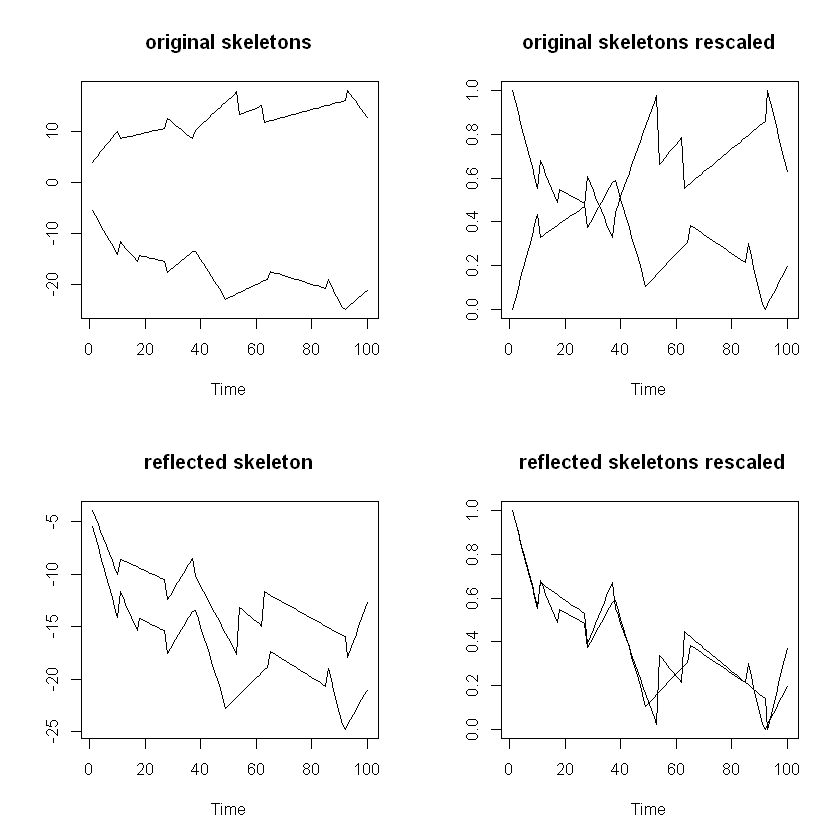

In [17]:
par(mfrow = c(2,2))
Y <- matrix(unlist(lapply(1:2, function(i) predict(not.x[[i]]))), ncol = 2)
                          
ts.plot(Y, main = "original skeletons")
ts.plot(apply(Y,2,function(i) (i-min(i))/(max(i)-min(i))), main = "original skeletons rescaled")
              
Y[,2] <- -Y[,2]
ts.plot(Y, main = "reflected skeleton")
ts.plot(apply(Y,2,function(i) (i-min(i))/(max(i)-min(i))), main = " reflected skeletons rescaled")